<a href="https://colab.research.google.com/github/sainikhila11/INFO5731-Group2-FinalProject/blob/main/Manohar_PsyTAR_Code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Correctness

In [ ]:
# !pip install openai==0.28
# !pip install openai pandas openpyxl
import pandas as pd
import openai
from google.colab import files

# Initialize OpenAI API key
openai.api_key = 'sk-proj-9gpI8AenRrdW9leB5KM6T3BlbkFJms1AEo0USSfymPGzCZmt'

PSY_TAR_FILE_NAME = 'PsyTAR_dataset.xlsx'
SNOMED_FILE_NAME = 'snomed_dataset.xlsx'

def load_data():
    print("Please upload your Excel file:")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return None

    file_name = next(iter(uploaded))
    xls = pd.ExcelFile(file_name)

    # Strip and clean sheet names to remove potential hidden characters
    clean_sheet_names = {sheet: sheet.strip() for sheet in xls.sheet_names}
    print("Available sheets:", clean_sheet_names.values())

    desired_sheets = ['ADR_Mapped', 'Withdraw_Mapped', 'SSI_Mapped', 'DI_Mapped']
    # Normalize and strip desired sheets for consistent comparison
    normalized_desired_sheets = [sheet.strip() for sheet in desired_sheets]

    # Check and load only the sheets that match the normalized desired sheets
    available_sheets = {name: real_name for real_name, name in clean_sheet_names.items() if name in normalized_desired_sheets}
    print(f"Loading sheets: {available_sheets.keys()}")

    # Load the available sheets into a dictionary of DataFrames, using cleaned names
    sheets_data = {name: pd.read_excel(xls, sheet_name=real_name) for name, real_name in available_sheets.items()}
    return sheets_data



def prepare_snomed_dict():
    """Loads the SNOMED dataset and creates a dictionary for fast lookups of USPreferredTerms."""
    # Loading the SNOMED dataset
    snomed_df = pd.read_excel(SNOMED_FILE_NAME)
    snomed_df['ConceptID'] = snomed_df['ConceptID'].astype(str).str.strip()
    # Creating a dictionary with ConceptID as keys and USPreferredTerm as values
    return pd.Series(snomed_df['USPreferredTerm'].values, index=snomed_df['ConceptID']).to_dict()

def batch_validate_terms(df, snomed_dict, column, batch_size=10):
    total_valid = 0
    total_rows = 0
    prompts = []
    indices = []

    for index, row in df.iterrows():
        snomed_ct_code = row['SNOMED_CT_Code']
        if snomed_ct_code in snomed_dict:
            prompt = f"Does the description '{row[column].lower()}' conceptually relate to or can it be understood as describing the SNOMED-CT condition '{snomed_dict[snomed_ct_code]}'? Answer 'yes' or 'no'."
            prompts.append(prompt)
            indices.append(index)
            if len(prompts) == batch_size:
                responses = send_batch_to_openai(prompts, batch_size)
                total_valid += process_responses(responses, df, indices)
                prompts = []
                indices = []
        total_rows += 1

    if prompts:  # Processing the last batch if it's not empty
        responses = send_batch_to_openai(prompts, len(prompts))
        total_valid += process_responses(responses, df, indices)

    return total_valid, total_rows

def send_batch_to_openai(prompts, n):
    return openai.Completion.create(
        model="gpt-3.5-turbo-instruct",
        prompt="\n".join(prompts),
        max_tokens=50,
        n=n,
        stop=None
    )

def process_responses(responses, df, indices):
    valid_count = 0
    for i, choice in enumerate(responses['choices']):
        result_text = choice['text'].strip().lower()
        # Check if the response starts with 'yes' or 'no'
        response_words = result_text.split()
        if response_words:
            is_valid = response_words[0] == 'yes'
        else:
            is_valid = False  # If no words were found, mark as invalid
        df.at[indices[i], 'Is_Valid'] = is_valid
        if is_valid:
            valid_count += 1
    return valid_count


def main():
    data = load_data()
    if not data:  # Check if data loading was successful
        print("Failed to load data. Exiting...")
        return

    snomed_dict = prepare_snomed_dict()
    if not snomed_dict:  # Check if SNOMED dictionary was successfully prepared
        print("Failed to load SNOMED dictionary. Exiting...")
        return

    overall_valid = 0
    overall_rows = 0

    # Mapping of sheets to the columns they should have for validation
    columns_by_sheet = {
        'ADR_Mapped': 'ADRs',
        'Withdraw_Mapped': 'WDs',
        'SSI_Mapped': 'SSI',
        'DI_Mapped': 'DIs'
    }

    # Iterate over each sheet and perform the validations
    for sheet_name, df in data.items():
        if sheet_name in columns_by_sheet:
            column = columns_by_sheet[sheet_name]
            # Ensure the column exists in the DataFrame to avoid KeyError
            if column in df.columns:
                df['SNOMED_CT_Code'] = df['SNOMED-CT'].str.extract(r'(?i)/fn/(\d+)]').astype(str)
                valid, total = batch_validate_terms(df, snomed_dict, column)
                correctness_percentage = (valid / total) * 100 if total > 0 else 0
                print(f"Correctness for {sheet_name}: {correctness_percentage:.2f}%")
                overall_valid += valid
                overall_rows += total
            else:
                print(f"Column '{column}' not found in sheet '{sheet_name}'")
        else:
            print(f"Sheet '{sheet_name}' is not configured for processing.")

    # Calculate and print overall correctness
    if overall_rows > 0:
        overall_correctness = (overall_valid / overall_rows) * 100
        print(f"Overall Correctness Percentage Across All Sheets: {overall_correctness:.2f}%")
    else:
        print("No data was processed.")

if __name__ == "__main__":
    main()


Please upload your Excel file:


Saving PsyTAR_dataset.xlsx to PsyTAR_dataset (24).xlsx
Available sheets: dict_values(['License', 'read_me', 'Sample', 'Sentence_Labeling', 'ADR_Identified', 'ADR_Mapped', 'WD_Identified', 'Withdraw_Mapped', 'SSI_Identified', 'SSI_Mapped', 'DI_Identified', 'DI_Mapped'])
Loading sheets: dict_keys(['ADR_Mapped', 'Withdraw_Mapped', 'SSI_Mapped', 'DI_Mapped'])
Correctness for ADR_Mapped: 57.88%
Correctness for Withdraw_Mapped: 50.51%
Correctness for SSI_Mapped: 75.64%
Correctness for DI_Mapped: 69.07%
Overall Correctness Percentage Across All Sheets: 61.41%


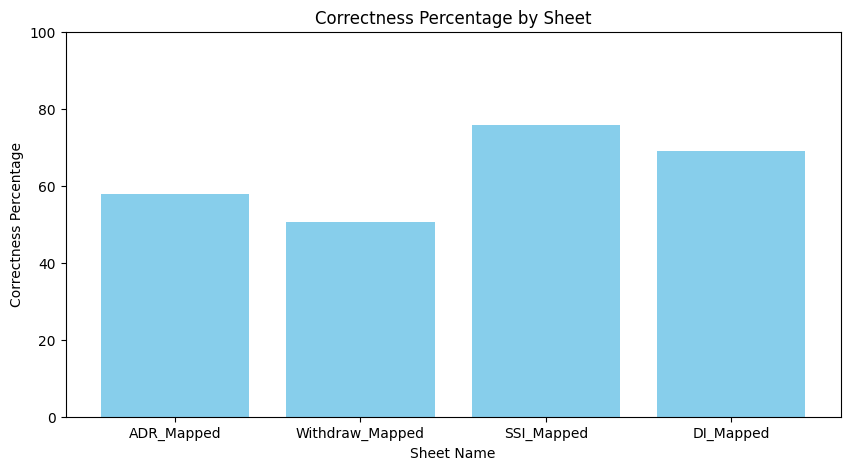

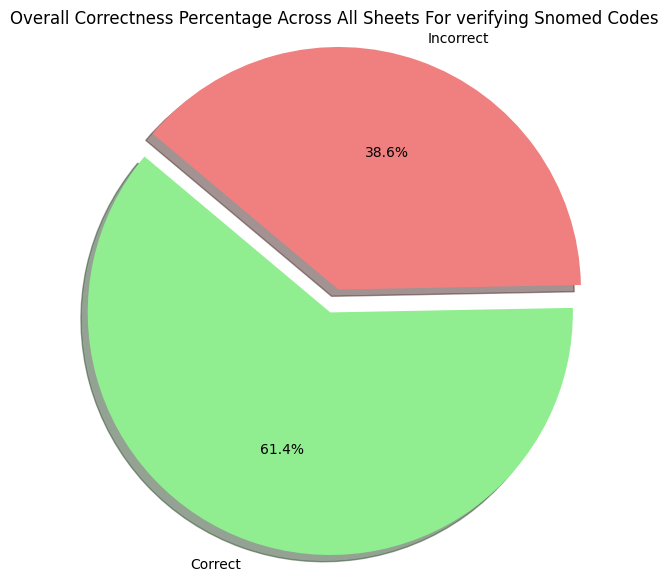

In [ ]:
import matplotlib.pyplot as plt

correctness_dict = {
    'ADR_Mapped': 57.88,
    'Withdraw_Mapped':50.51,
    'SSI_Mapped': 75.64,
    'DI_Mapped': 69.07
}

overall_correctness = 61.41  # Example overall correctness percentage

def visualize_correctness(correctness_dict, overall_correctness):
    # Bar chart for each sheet's correctness
    plt.figure(figsize=(10, 5))
    plt.bar(correctness_dict.keys(), correctness_dict.values(), color='skyblue')
    plt.title('Correctness Percentage by Sheet')
    plt.xlabel('Sheet Name')
    plt.ylabel('Correctness Percentage')
    plt.ylim(0, 100)  # Set y-axis limits to show percentages clearly
    plt.show()

    # Pie chart for overall correctness
    plt.figure(figsize=(7, 7))
    labels = ['Correct', 'Incorrect']
    sizes = [overall_correctness, 100 - overall_correctness]
    colors = ['lightgreen', 'lightcoral']
    explode = (0.1, 0)  # Only "explode" the first slice (i.e., 'Correct')
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)
    plt.title('Overall Correctness Percentage Across All Sheets For verifying Snomed Codes')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

visualize_correctness(correctness_dict, overall_correctness)


Saving PsyTAR_dataset.xlsx to PsyTAR_dataset (12).xlsx


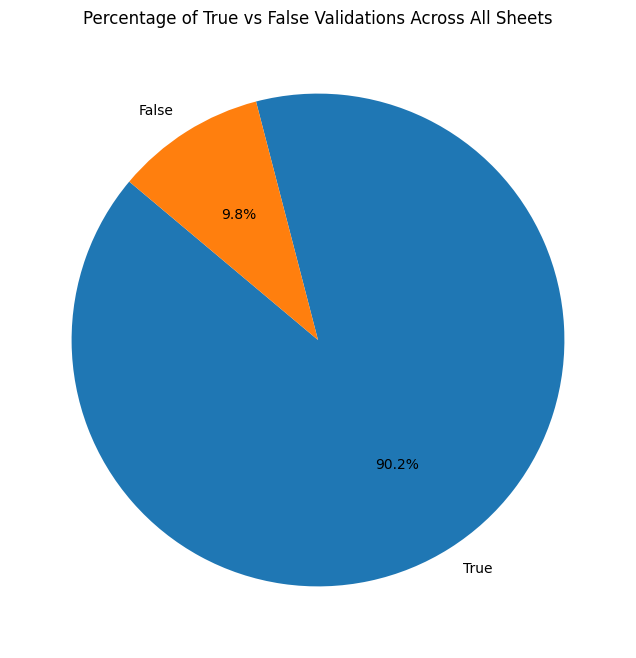

In [ ]:
import openai
import pandas as pd
from google.colab import files
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
# Initialize OpenAI API key
openai.api_key = 'sk-proj-9gpI8AenRrdW9leB5KM6T3BlbkFJms1AEo0USSfymPGzCZmt'

def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    sheets = ['ADR_Identified', 'WD_Identified', 'SSI_Identified', 'DI_Identified']
    return {sheet: pd.read_excel(file_name, sheet_name=sheet) for sheet in sheets}

def get_embeddings(texts, engine="text-embedding-ada-002"):
    try:
        response = openai.Embedding.create(input=texts, engine=engine)
        embeddings = [item['embedding'] for item in response['data']]
        return embeddings
    except Exception as e:
        print(f"Error getting embeddings: {e}")
        return [None] * len(texts)

def validate_terms(sentence, terms):
    try:
        terms_text = ", ".join(terms)
        prompt = f"Are the following terms '{terms_text}' conceptually relevant to the sentence '{sentence}' from an medical point of view? Answer with 'yes' or 'no' only."
        response = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",
            prompt=prompt,
            max_tokens=100,
            temperature=0.1
        )
        answers = response.choices[0].text.strip().lower().split(',')
        return any(answer.strip() == 'yes' for answer in answers)
    except Exception as e:
        print(f"Error querying OpenAI: {e}")
        return False

def batch_validate(df, columns):
    results = []
    batch_size = 100
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        batch = df.iloc[start:end]
        for i, row in batch.iterrows():
            # Filter out any NaN values directly here and ensure only specified columns are processed
            terms = [str(row[col]) for col in columns if col in row and not pd.isna(row[col])]
            if not terms:  # If there are no valid terms after filtering, consider the row invalid
                results.append(False)
                continue
            is_valid = validate_terms(row['sentences'], terms)
            results.append(is_valid)
    return results


def main():
    datasets = load_data()
    all_valid_results = []  # List to store all validation results

    columns_by_sheet = {
        'ADR_Identified': ['ADR1', 'ADR2', 'ADR3'],
        'WD_Identified': ['WD1', 'WD2', 'WD3'],
        'SSI_Identified': ['SSI1', 'SSI2'],
        'DI_Identified': ['DI1']
    }

    for sheet_name, df in datasets.items():
        if sheet_name in columns_by_sheet:
            columns = columns_by_sheet[sheet_name]
            validity = batch_validate(df, columns)
            df['Is_Valid'] = validity
            all_valid_results.extend(validity)
    results_df = pd.DataFrame(all_valid_results, columns=['Is_Valid'])

    # Now you can plot the combined results
    plot_combined_validation_results(results_df)

def plot_combined_validation_results(df):
    valid_counts = df['Is_Valid'].value_counts(normalize=True) * 100

    # Create a pie chart for combined results
    plt.figure(figsize=(8, 8))
    plt.pie(valid_counts, labels=valid_counts.index.astype(str), autopct='%1.1f%%', startangle=140)
    plt.title('Percentage of True vs False Validations Across All Sheets')
    plt.show()

if __name__ == "__main__":
    main()


## **Checking the Content Quality Metrics using Sentiment consistency for social media sentences**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.2 MB/s eta 0:00:00


Saving PsyTAR_dataset.xlsx to PsyTAR_dataset.xlsx
Processing sheet: ADR_Identified
Uniqueness Percentage for ADR_Identified: 99.67697277341946
                                              sentences sentiment
0     extreme weight gain, short-term memory loss, h...  negative
1           COMPLETELY DESTROYED SEXUALLY FUNCTIONING .  negative
2     Just TWO tablets of Lexapro 10mg completely de...  negative
3       It's called PSSD: post-SSRI sexual dysfunction.   neutral
4     And there is a chance that it will give you PS...  negative
...                                                 ...       ...
2162  Exercising and dieting don't seem to get the w...  negative
2163  Stomach problems early on: bloating, nausea, c...  negative
2164            No side effects now accept for yawning.   neutral
2165  The only side effects I experienced were mild ...   neutral
2166  The side effects did go away after about 4 day...  positive

[2167 rows x 2 columns]


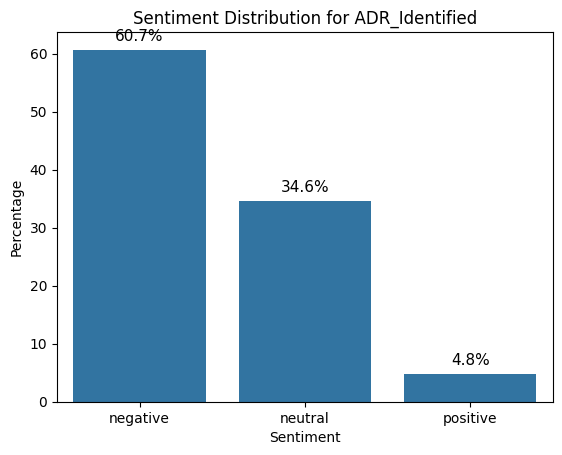

Processing sheet: WD_Identified
Uniqueness Percentage for WD_Identified: 100.0
                                             sentences sentiment
0    I have flu-like symptoms, dizziness, major moo...  negative
1    I would never have guessed withdrawal would be...  negative
2    I can't imagine going through the withdrawal a...  negative
3      The withdrawal process has been very difficult.  negative
4    Even though I tapered down in 1/4 pill increme...  negative
..                                                 ...       ...
434           could miss a dose or two and no problem.   neutral
435  When I forget to take my medication I get vert...  negative
436  However missing a dose can bring on a huge cha...  negative
437  along with severe nausea, sweating and dizziness.  negative
438  A missed dosage causes symptons like the flu w...  negative

[439 rows x 2 columns]


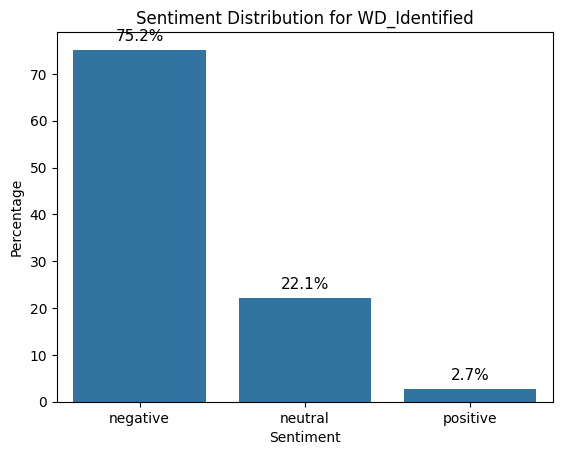

Processing sheet: SSI_Identified
Uniqueness Percentage for SSI_Identified: 100.0
                                             sentences sentiment
0    My anxiety is worse than before, and I've been...  negative
1    I did experience relief of my depression initi...  positive
2    Jaw jacking/clenching teeth, headaches, vomitt...  negative
3    Clumsy and at first gave me tons of energy but...   neutral
4    The increase in anxiety has made me stop takin...  negative
..                                                 ...       ...
784                  Able to deal with anxiety better.  positive
785  Able to handle stress better and to look at th...  positive
786  I have been taking 75mg dosage for a year now ...  positive
787  The negative obsessive thoughts playing over a...  positive
788  I no longer have that sense of dread every mor...  positive

[789 rows x 2 columns]


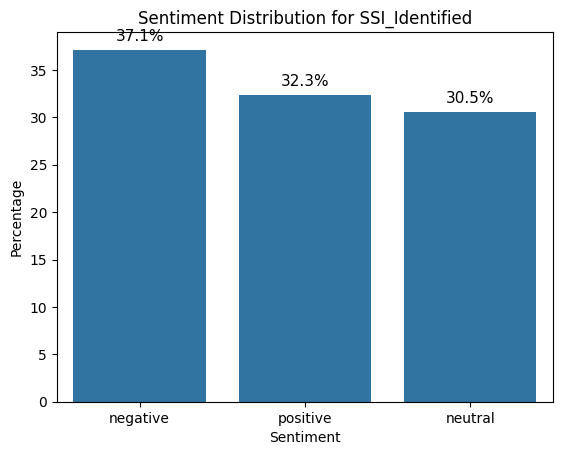

Processing sheet: DI_Identified
Uniqueness Percentage for DI_Identified: 100.0
                                             sentences sentiment
0    I did experience relief of my depression initi...  positive
1    I would rather have panic attacks and be depre...  negative
2    I was taking Ativan, Ambien, Atenolol and Lexa...  negative
3    Constant yawning,severe tremors,headache, lost...  negative
4    It was frankly disturbing, and I think going o...  positive
..                                                 ...       ...
512                  Able to deal with anxiety better.  positive
513  Able to handle stress better and to look at th...  positive
514  I have been taking 75mg dosage for a year now ...  positive
515  The negative obsessive thoughts playing over a...  positive
516  I no longer have that sense of dread every mor...  positive

[517 rows x 2 columns]


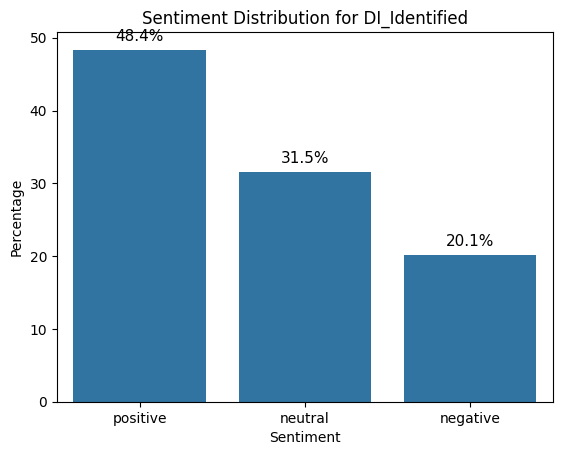

<ipython-input-1-b1efb7e83990>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sheet_names, y=uniqueness_values, palette='viridis')


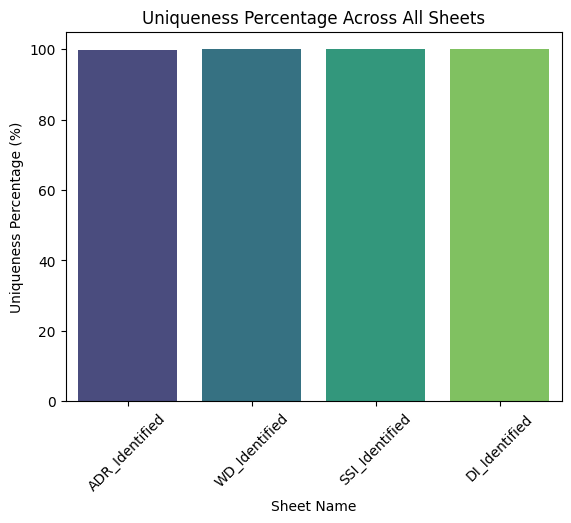

In [ ]:
!pip install openai==0.28
import openai
import pandas as pd
from google.colab import files
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns

# Function to upload and load multiple sheets from the dataset
def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    sheets = ['ADR_Identified', 'WD_Identified', 'SSI_Identified', 'DI_Identified']
    return {sheet: pd.read_excel(file_name, sheet_name=sheet) for sheet in sheets}

# Initialize OpenAI API key
openai.api_key = ''

# Function to analyze sentiment using GPT-3.5 Turbo
def analyze_sentiment(text):
    try:
        response = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",
            prompt=f"Analyze the sentiment of this text and categorize as positive, negative, or neutral: {text}",
            max_tokens=50,
            temperature=0.3
        )
        sentiment_text = response.choices[0].text.strip().lower()
        if "positive" in sentiment_text:
            return "positive"
        elif "negative" in sentiment_text:
            return "negative"
        else:
            return "neutral"
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return "error"

# Function to calculate textual uniqueness using hashing
def calculate_uniqueness(texts):
    hash_set = set()
    for text in texts:
        hash_value = hashlib.sha256(text.encode()).hexdigest()
        hash_set.add(hash_value)
    return len(hash_set) / len(texts) * 100

# Function to plot sentiment distribution for a specific sheet
def plot_sentiment_distribution(sentiments, sheet_name):
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True) * 100  # Calculate percentage
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    plt.title(f'Sentiment Distribution for {sheet_name}')
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage')

    # Adding the percentage labels on top of each bar
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 10),
                    textcoords='offset points')

    plt.show()

# Function to plot uniqueness distribution for all sheets
def plot_uniqueness_distribution(uniqueness_data):
    sheet_names = list(uniqueness_data.keys())
    uniqueness_values = list(uniqueness_data.values())
    sns.barplot(x=sheet_names, y=uniqueness_values, palette='viridis')
    plt.title('Uniqueness Percentage Across All Sheets')
    plt.xlabel('Sheet Name')
    plt.ylabel('Uniqueness Percentage (%)')
    plt.xticks(rotation=45)
    plt.show()

# Main function to execute data processing for multiple sheets
def main():
    datasets = load_data()
    uniqueness_data = {}
    for sheet_name, df in datasets.items():
        print(f"Processing sheet: {sheet_name}")
        df['sentiment'] = df['sentences'].apply(analyze_sentiment)

        # Calculate and display uniqueness for each sheet
        uniqueness_percentage = calculate_uniqueness(df['sentences'].tolist())
        uniqueness_data[sheet_name] = uniqueness_percentage  # Store uniqueness data
        print(f"Uniqueness Percentage for {sheet_name}:", uniqueness_percentage)

        # Display DataFrame for review
        print(df[['sentences', 'sentiment']])

        # Plotting sentiment distribution for the current sheet
        plot_sentiment_distribution(df['sentiment'], sheet_name)

    # Plotting uniqueness distribution after processing all sheets
    plot_uniqueness_distribution(uniqueness_data)

if __name__ == "__main__":
    main()


# checking the completeness of **dataset**

Saving PsyTAR_dataset.xlsx to PsyTAR_dataset (13).xlsx
Sheet 'License' is empty.
Completeness for read_me:
Unnamed: 0    39.285714
Unnamed: 1    39.285714
Unnamed: 2    82.142857
Unnamed: 3    82.142857
Unnamed: 4    10.714286
Unnamed: 5     7.142857
dtype: float64

Completeness for Sample:
index              100.000000
comment_index      100.000000
comment_id         100.000000
drug_id            100.000000
rating             100.000000
disorder           100.000000
side-effect         98.092031
comment             86.083053
gender              98.877666
age                 98.653199
dosage_duration     99.663300
date               100.000000
category           100.000000
dtype: float64

Completeness for Sentence_Labeling:
id                 99.983361
comment_id         99.983361
drug_id            99.983361
sentence_index     99.983361
sentences          99.966722
ADR                36.089850
WD                  7.304493
EF                 18.103161
INF                 5.623960
SSI  

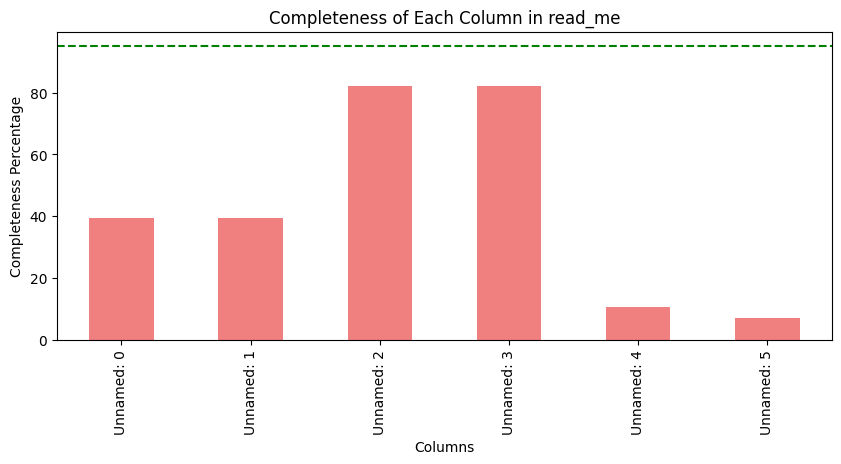

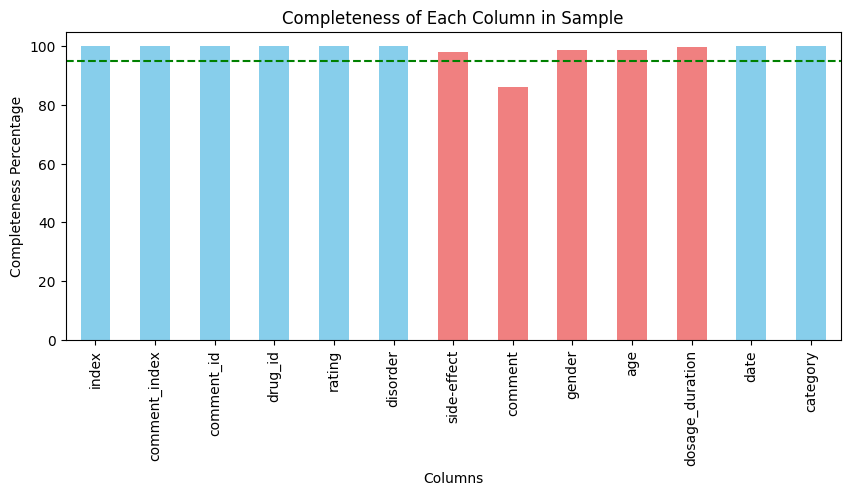

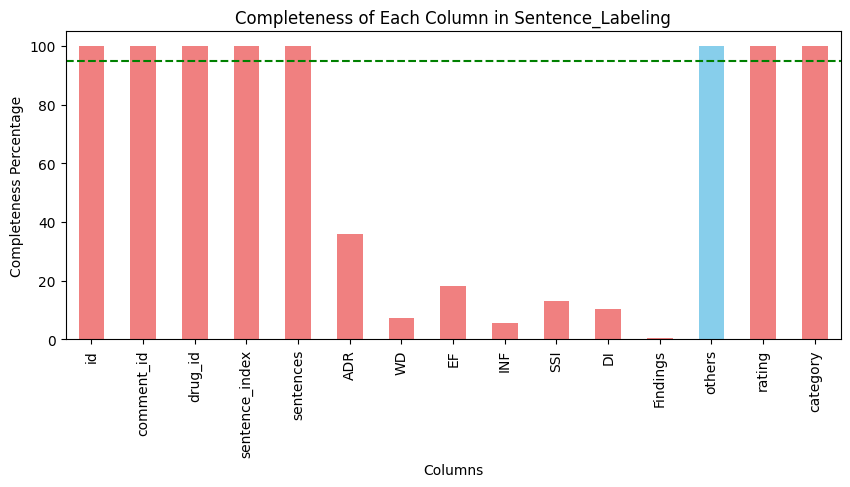

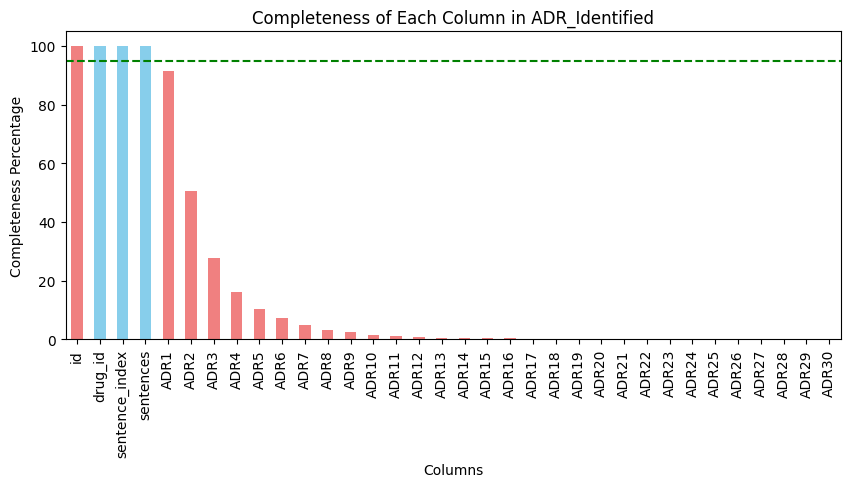

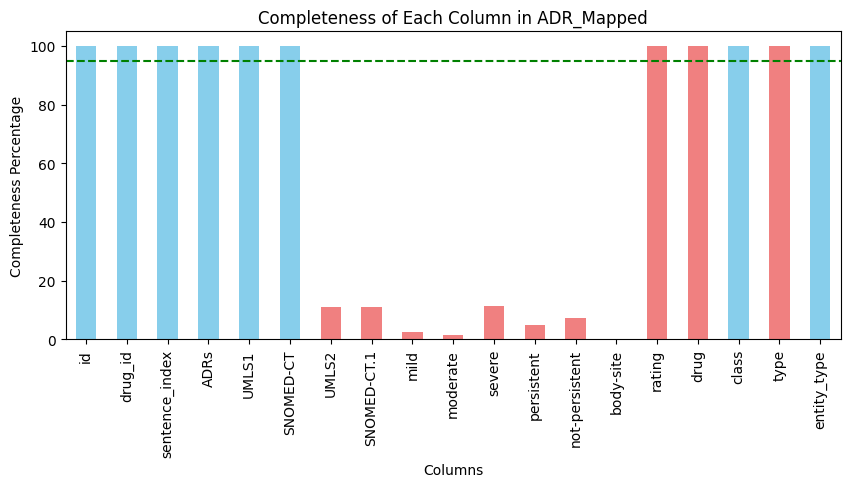

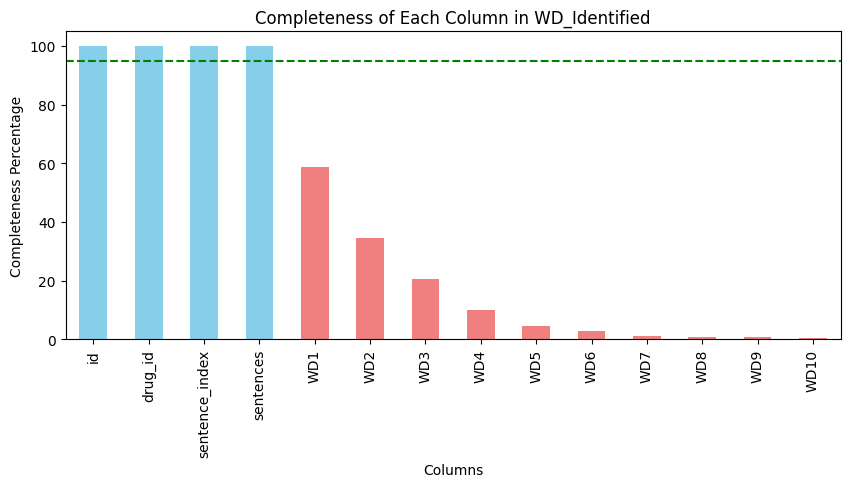

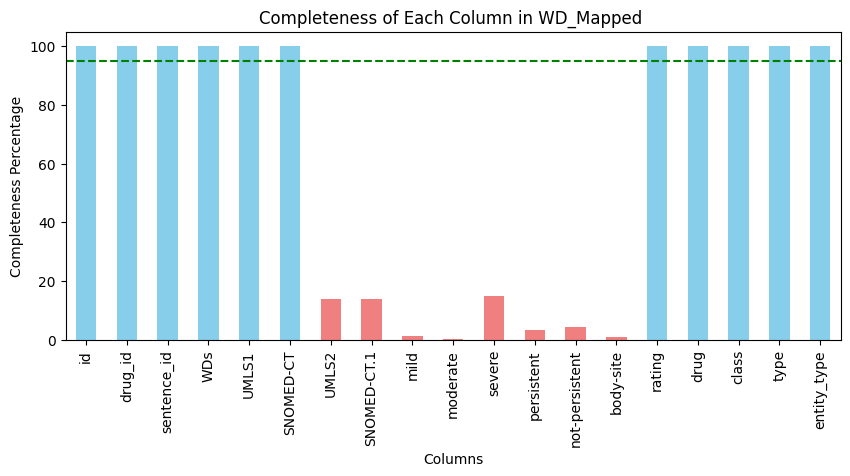

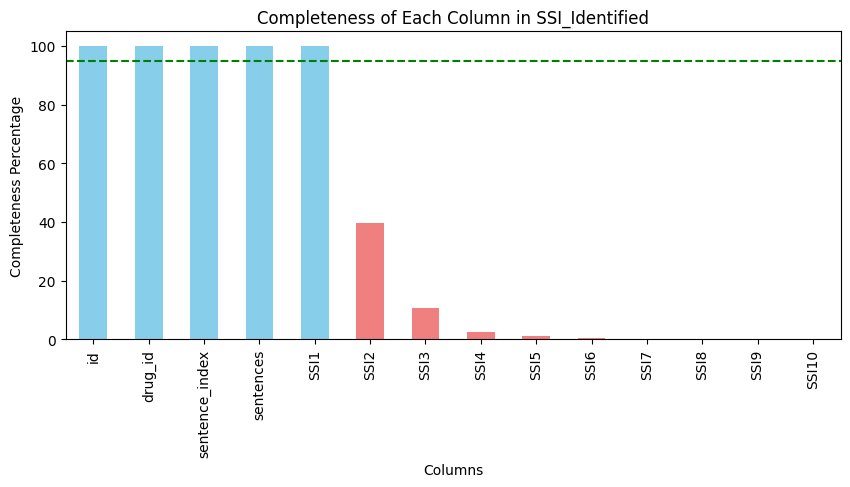

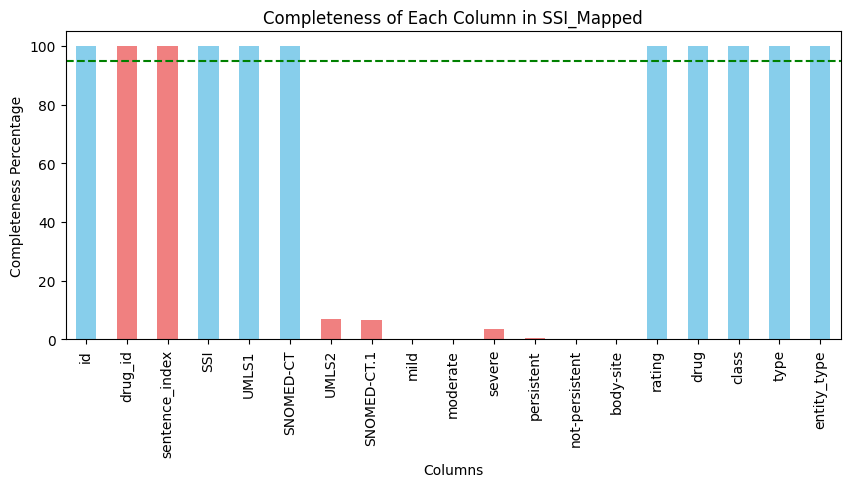

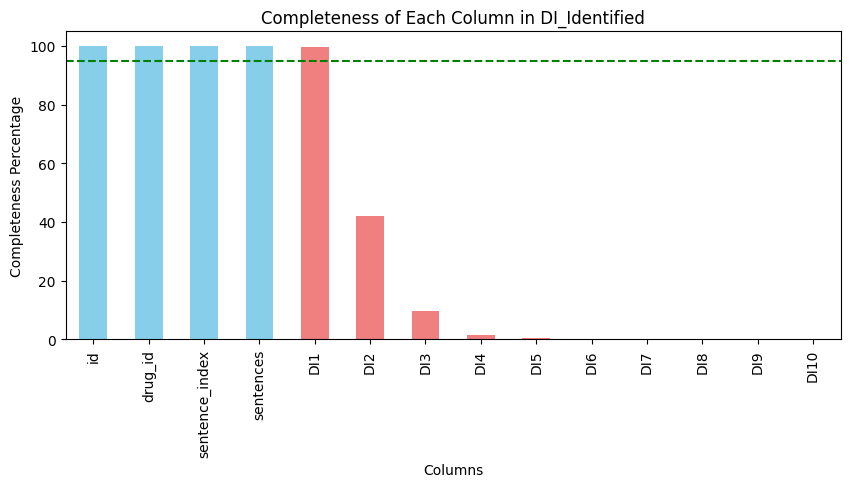

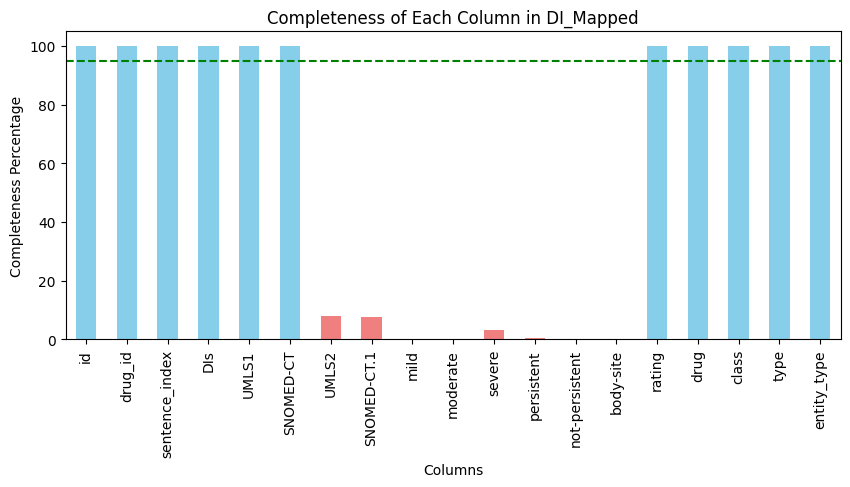

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    return pd.read_excel(file_name, sheet_name=None)

def calculate_completeness(df):
    if df.empty:
        return None  # Return None if DataFrame is empty
    total_counts = df.shape[0]
    non_null_counts = df.count()
    completeness = (non_null_counts / total_counts) * 100
    return completeness

def visualize_completeness(completeness_dict):
    for sheet_name, completeness in completeness_dict.items():
        if completeness is not None:  # Check if completeness was calculated
            plt.figure(figsize=(10, 4))  # Consistent figure size
            colors = ['skyblue' if val == 100 else 'lightcoral' for val in completeness]
            completeness.plot(kind='bar', color=colors)
            plt.title(f'Completeness of Each Column in {sheet_name}')
            plt.xlabel('Columns')
            plt.ylabel('Completeness Percentage')
            plt.axhline(y=95, color='green', linestyle='--')  # Optional: Threshold line
            plt.show()
        else:
            print(f"No data to display for {sheet_name}. Sheet may be empty.")


def main():
    sheets = load_data()
    completeness_dict = {}
    for sheet_name, df in sheets.items():
        if not df.empty:  # Check if the DataFrame is not empty
            completeness = calculate_completeness(df)
            if completeness is not None:
                completeness_dict[sheet_name] = completeness
                print(f"Completeness for {sheet_name}:\n{completeness}\n")
            else:
                print(f"Sheet '{sheet_name}' contains no data.")
        else:
            print(f"Sheet '{sheet_name}' is empty.")
    visualize_completeness(completeness_dict)

if __name__ == "__main__":
    main()


Saving PsyTAR_dataset.xlsx to PsyTAR_dataset.xlsx
Overall completeness of the document: 50.67%


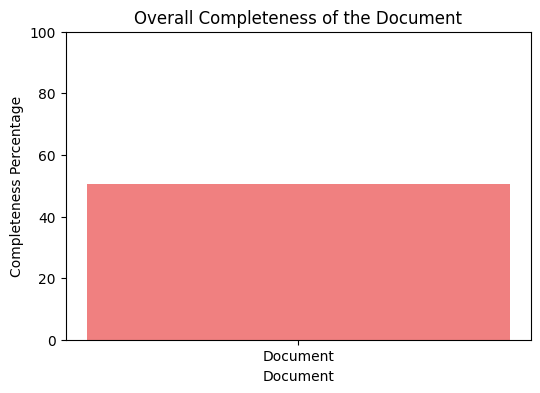

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    return pd.read_excel(file_name, sheet_name=None)

def calculate_overall_completeness(df):
    if df.empty:
        return None  # Return None if DataFrame is empty
    total_cells = df.size
    non_null_cells = df.notna().sum().sum()
    overall_completeness = (non_null_cells / total_cells) * 100
    return overall_completeness

def visualize_completeness(overall_completeness):
    plt.figure(figsize=(6, 4))
    plt.bar('Document', overall_completeness, color='skyblue' if overall_completeness == 100 else 'lightcoral')
    plt.title('Overall Completeness of the Document')
    plt.xlabel('Document')
    plt.ylabel('Completeness Percentage')
    plt.ylim([0, 100])
    plt.show()

def main():
    sheets = load_data()
    total_non_null_cells = 0
    total_cells = 0

    for sheet_name, df in sheets.items():
        if not df.empty:
            non_null_cells = df.notna().sum().sum()
            total_cells += df.size
            total_non_null_cells += non_null_cells

    if total_cells > 0:
        overall_completeness = (total_non_null_cells / total_cells) * 100
        print(f"Overall completeness of the document: {overall_completeness:.2f}%")
        visualize_completeness(overall_completeness)
    else:
        print("The document is empty or contains no data.")

if __name__ == "__main__":
    main()
